In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing

In [4]:
# Download latest version
#path = kagglehub.dataset_download("adilshamim8/sleep-cycle-and-productivity")

#print("Path to dataset files:", path)

df = pd.read_csv(".//sleep_cycle_productivity.csv")

In [5]:
 df_features = df[['Age', 'Sleep Start Time',
       'Sleep End Time', 'Total Sleep Hours', 'Sleep Quality',
       'Exercise (mins/day)', 'Caffeine Intake (mg)',
       'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)', 'Mood Score', 'Stress Level']]


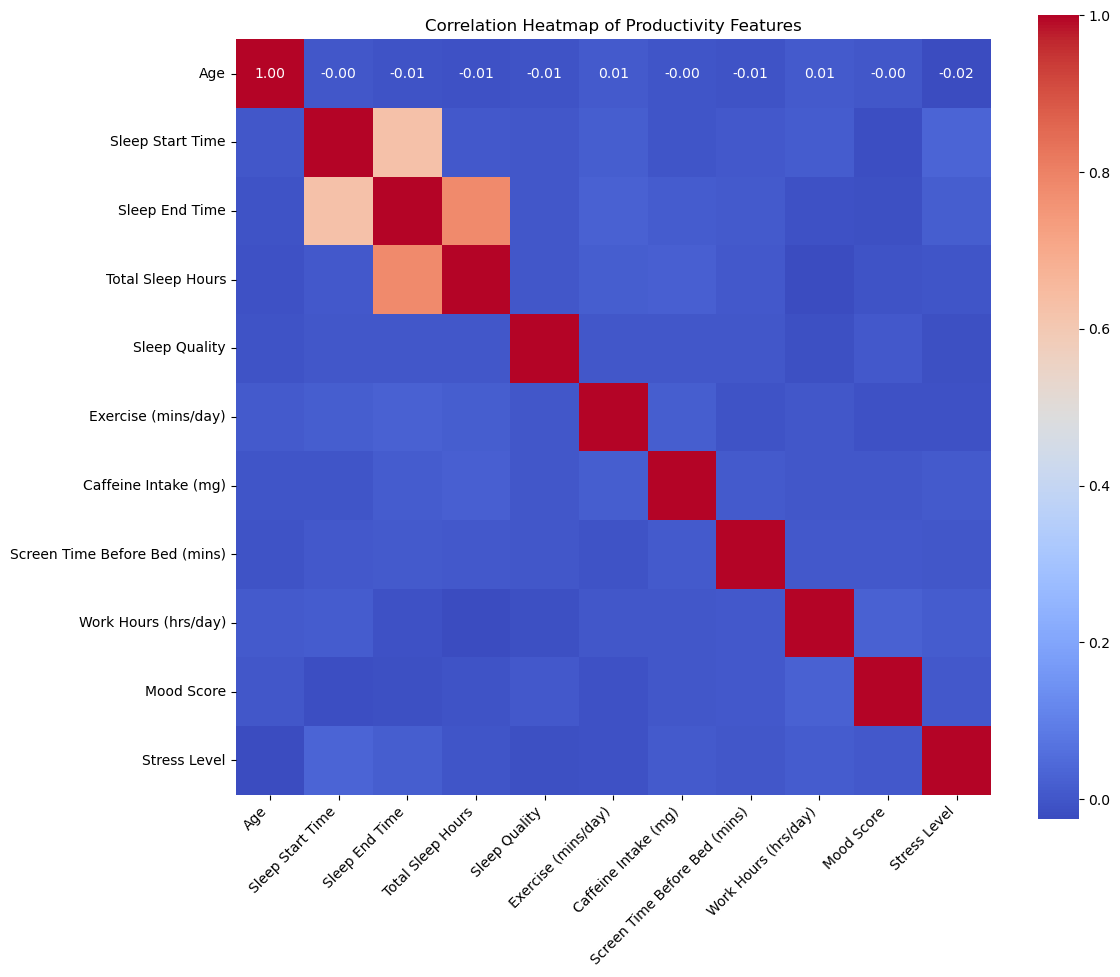

In [6]:
# Compute the correlation matrix
correlation_matrix = df_features.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Productivity Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# this shows us data relation ships
# The darker red shows strong positive impact on productivity 
# darker blue represents strong negative impact on productivity

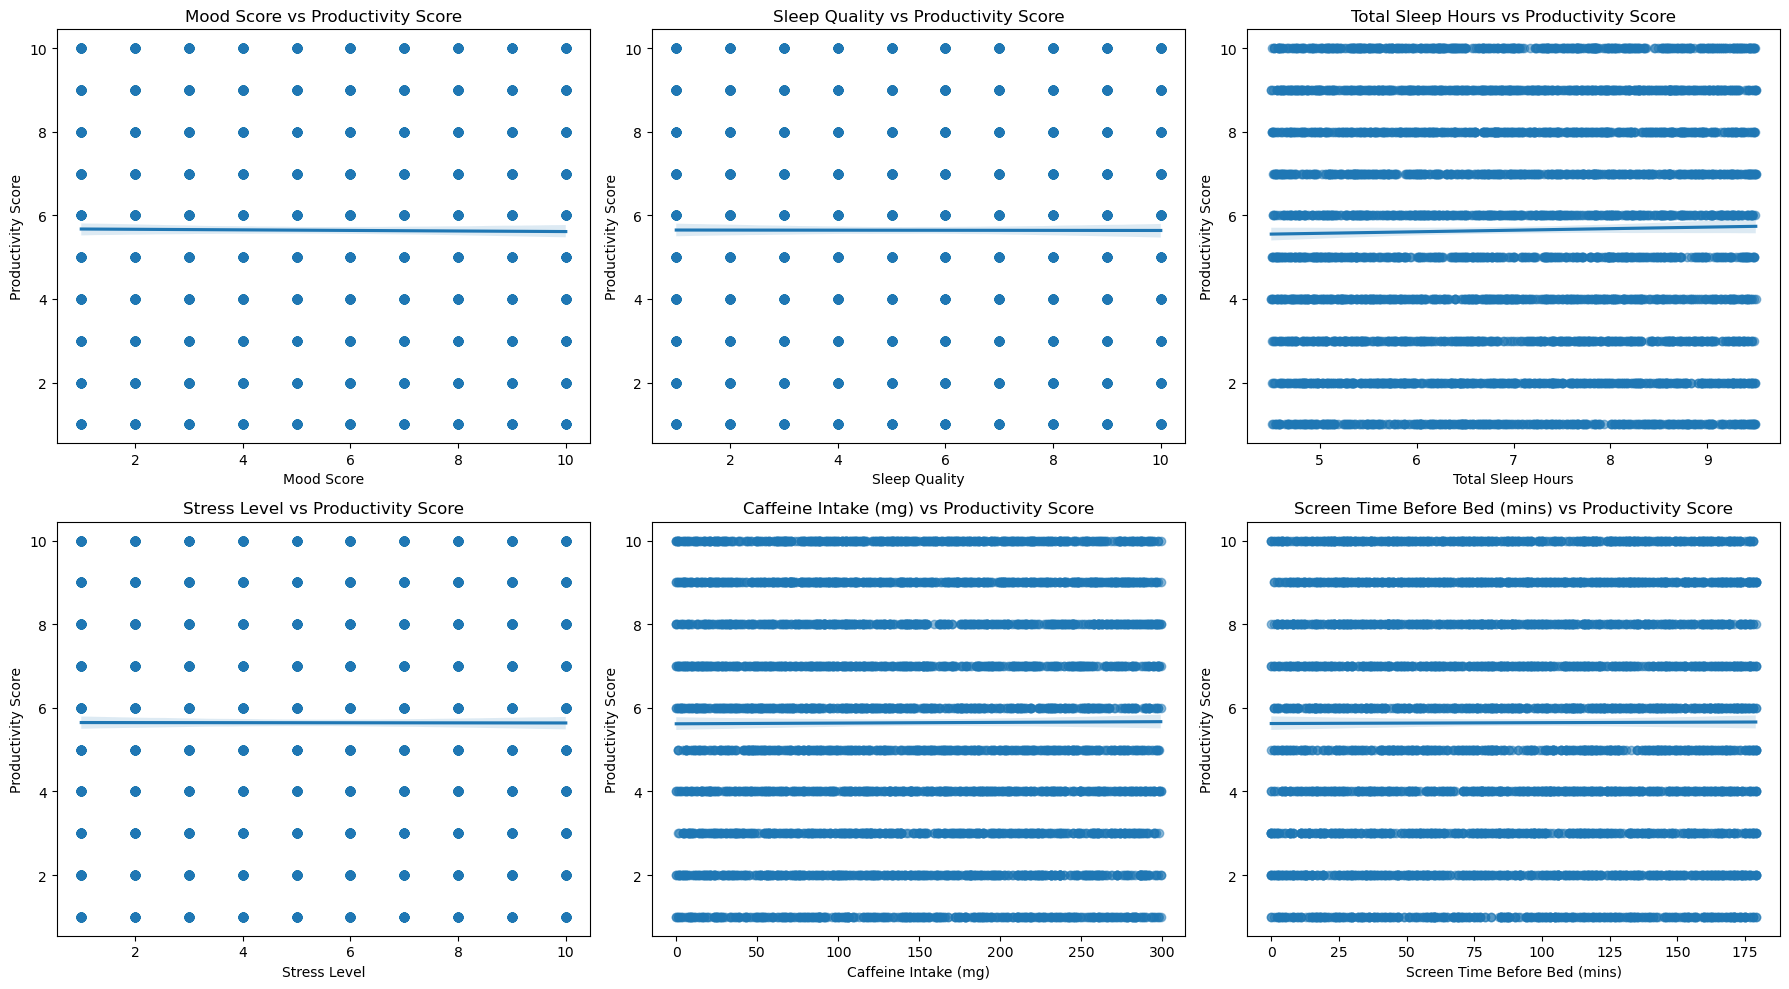

In [9]:
# Create scatter plots for a few interesting pairs with high correlation to Productivity Score

# Define pairs of features to plot against Productivity Score
features_to_plot = ['Mood Score', 'Sleep Quality', 'Total Sleep Hours', 
                    'Stress Level', 'Caffeine Intake (mg)', 
                    'Screen Time Before Bed (mins)']

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.ravel()

for i, feature in enumerate(features_to_plot):
    sns.regplot(x=feature, y='Productivity Score', data=df, ax=axs[i], scatter_kws={'alpha':0.5})
    axs[i].set_title(f'{feature} vs Productivity Score')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Productivity Score')

plt.tight_layout()
plt.show()

# this again showing the the total sleep being the main impact to the productivity
# maybe for final submition of paper we can just include that one chart as a result.

Looking into potintial bias with gender. Basically determining if gender has negative impact on the model results

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [11]:
# Recreate the feature matrix X and target y
X = df[['Age', 'Sleep Start Time', 'Sleep End Time', 'Total Sleep Hours', 'Sleep Quality',
        'Exercise (mins/day)', 'Caffeine Intake (mg)', 'Screen Time Before Bed (mins)',
        'Work Hours (hrs/day)', 'Mood Score', 'Stress Level']]
y = df['Productivity Score']

In [12]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
# Retrain the regression model
regr = LinearRegression()
regr.fit(X_scaled, y)

LinearRegression()

In [14]:
# Make predictions
df['Predicted Productivity'] = regr.predict(X_scaled)
df['Prediction Error'] = abs(df['Predicted Productivity'] - df['Productivity Score'])

In [15]:
# Group-wise comparison
grouped_stats = df.groupby('Gender')[['Productivity Score', 'Predicted Productivity', 'Prediction Error']].mean().round(2)
grouped_stats

,Productivity Score,Predicted Productivity,Prediction Error
Gender,,,
Female,5.72,5.64,2.49
Male,5.60,5.65,2.51
Other,5.61,5.64,2.51


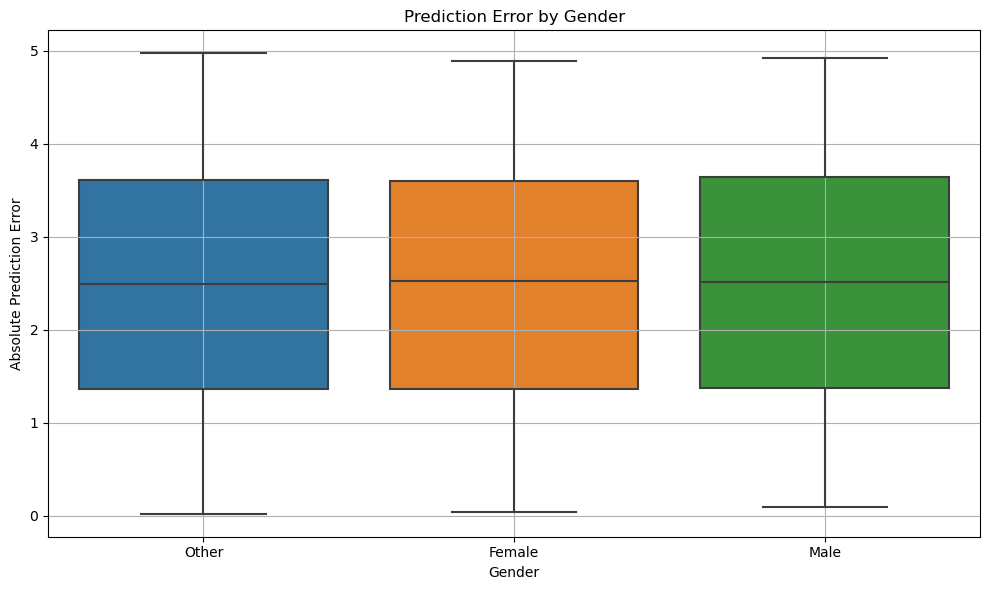

In [16]:
# Create boxplots of prediction errors by gender group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Prediction Error', data=df)
plt.title('Prediction Error by Gender')
plt.ylabel('Absolute Prediction Error')
plt.xlabel('Gender')
plt.grid(True)
plt.tight_layout()
plt.show()

Boxplot and data shows there is very little difference between gender groups. Doesn't mean it is completely free of bias and likely should be removed anyways to be safe.

In [18]:
# Create age group bins
age_bins = [0, 25, 35, 50, 100]
age_labels = ['Under 25', '25–35', '36–50', 'Over 50']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

# Group-wise comparison for age groups
age_group_stats = df.groupby('Age Group')[['Productivity Score', 'Predicted Productivity', 'Prediction Error']].mean().round(2)
age_group_stats


C:\Users\someo\AppData\Local\Temp\ipykernel_7040\2784467946.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stats = df.groupby('Age Group')[['Productivity Score', 'Predicted Productivity', 'Prediction Error']].mean().round(2)


,Productivity Score,Predicted Productivity,Prediction Error
Age Group,,,
Under 25,5.71,5.68,2.47
25–35,5.73,5.66,2.53
36–50,5.55,5.64,2.50
Over 50,5.65,5.61,2.51


C:\Users\someo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


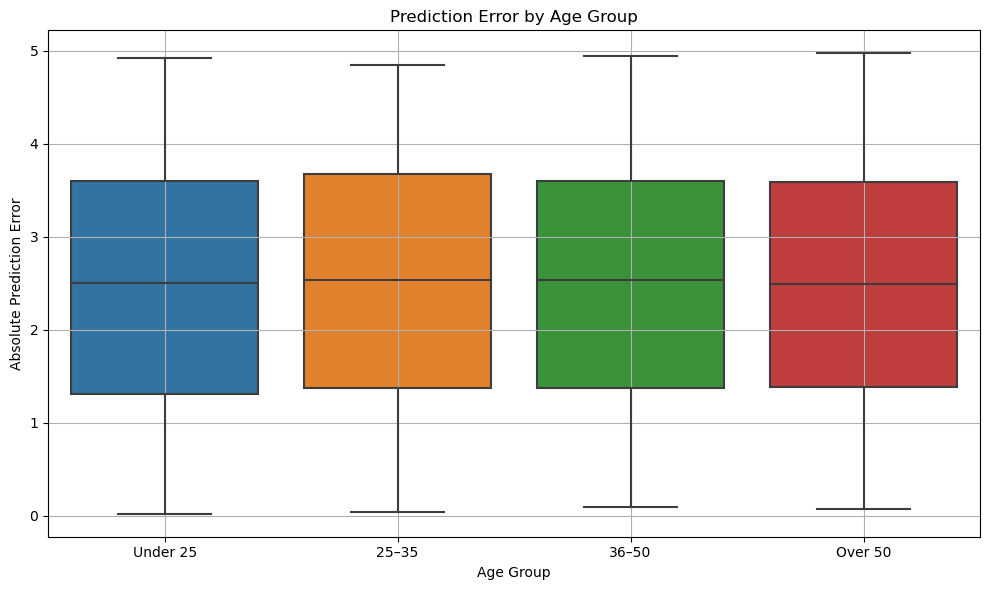

In [19]:
# check to see if age is likely to introduce bias
# Create a boxplot to visualize prediction error across age groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age Group', y='Prediction Error', data=df)
plt.title('Prediction Error by Age Group')
plt.ylabel('Absolute Prediction Error')
plt.xlabel('Age Group')
plt.grid(True)
plt.tight_layout()
plt.show()


The binned ages tend to tell the same story as gender as there is not large gaps in error between the groups.

Lets try removing them and testing the preditition error then.

In [55]:
# Define a new feature set that excludes demographic features (Age, Gender)
features_excluding_demographics = [
    'Sleep Start Time', 'Sleep End Time', 'Total Sleep Hours', 'Sleep Quality',
    'Exercise (mins/day)', 'Caffeine Intake (mg)', 'Screen Time Before Bed (mins)',
    'Work Hours (hrs/day)', 'Mood Score', 'Stress Level'
]

# Create new X and y
X_no_demo = df[features_excluding_demographics]
y = df['Productivity Score']

In [21]:
# Normalize the new feature set
scaler_no_demo = StandardScaler()
X_no_demo_scaled = scaler_no_demo.fit_transform(X_no_demo)

In [22]:
# Train a new linear regression model
regr_no_demo = LinearRegression()
regr_no_demo.fit(X_no_demo_scaled, y)

LinearRegression()

In [23]:
# Predict and calculate errors
df['Predicted Productivity (No Demographics)'] = regr_no_demo.predict(X_no_demo_scaled)
df['Prediction Error (No Demographics)'] = abs(df['Predicted Productivity (No Demographics)'] - df['Productivity Score'])


In [24]:
# Compare average prediction error with and without demographic features
comparison = df[['Prediction Error', 'Prediction Error (No Demographics)']].mean().round(3)
comparison

Prediction Error                      2.504
Prediction Error (No Demographics)    2.504
dtype: float64

In [52]:
X = df[['Sleep Start Time',
       'Sleep End Time', 'Total Sleep Hours', 'Sleep Quality',
       'Exercise (mins/day)', 'Caffeine Intake (mg)',
       'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)', 'Mood Score', 'Stress Level']]

#Normalize data
scaler = preprocessing.StandardScaler().fit(X)

In [54]:
# #Save columns for printing later
# cols = X.columns
# X = scaler.transform(X)
# y = df['Productivity Score'] 


# regr = linear_model.LinearRegression()
# regr.fit(X, y)

# print(regr.coef_)
# for i in range(len(regr.coef_[0])):
#     print(str(cols[i]) + ": " + str(regr.coef_[0][i]))

# print(df['Sleep End Time'])

Now moving to test a Lasso regression model to determine the most important features and allow it to remove those that are not impacting the model at all.

In [33]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np

In [42]:
# Train Lasso Regression (excluding demographic features, as per earlier decision)
lasso = Lasso(alpha=0.001)  # Alpha is the regularization strength
lasso.fit(X_no_demo_scaled, y)

Lasso(alpha=0.001)

In [56]:
# Predictions
df['Lasso Predicted Productivity'] = lasso.predict(X_no_demo_scaled)
df['Lasso Prediction Error'] = abs(df['Lasso Predicted Productivity'] - df['Productivity Score'])

In [57]:
# Evaluate performance
lasso_mae = mean_absolute_error(y, df['Lasso Predicted Productivity'])
lasso_rmse = np.sqrt(mean_squared_error(y, df['Lasso Predicted Productivity']))

In [58]:
# Get coefficients
lasso_coefficients = pd.Series(lasso.coef_, index=features_excluding_demographics).round(3)

lasso_mae, lasso_rmse, lasso_coefficients

(2.5045005771752993,
 2.8698147174925,
 Sleep Start Time                 0.000
 Sleep End Time                   0.056
 Total Sleep Hours                0.009
 Sleep Quality                   -0.003
 Exercise (mins/day)             -0.072
 Caffeine Intake (mg)             0.014
 Screen Time Before Bed (mins)    0.009
 Work Hours (hrs/day)            -0.045
 Mood Score                      -0.017
 Stress Level                    -0.003
 dtype: float64)

In [59]:
# now we want to test ridge regression since lasso really didn't give good results

In [60]:
from sklearn.linear_model import Ridge

In [61]:
# Train Ridge Regression with a modest regularization strength
ridge = Ridge(alpha=0.1)
ridge.fit(X_no_demo_scaled, y)

Ridge(alpha=0.1)

In [62]:
# Make predictions
df['Ridge Predicted Productivity'] = ridge.predict(X_no_demo_scaled)
df['Ridge Prediction Error'] = abs(df['Ridge Predicted Productivity'] - df['Productivity Score'])

In [63]:
# Evaluate performance
ridge_mae = mean_absolute_error(y, df['Ridge Predicted Productivity'])
ridge_rmse = np.sqrt(mean_squared_error(y, df['Ridge Predicted Productivity']))

# Get coefficients
ridge_coefficients = pd.Series(ridge.coef_, index=features_excluding_demographics).round(3)

ridge_mae, ridge_rmse, ridge_coefficients.sort_values(ascending=False)

(2.5044043856278293,
 2.8697628045160353,
 Total Sleep Hours                1.448
 Sleep Start Time                 1.145
 Caffeine Intake (mg)             0.015
 Screen Time Before Bed (mins)    0.010
 Sleep Quality                   -0.004
 Stress Level                    -0.004
 Mood Score                      -0.018
 Work Hours (hrs/day)            -0.046
 Exercise (mins/day)             -0.073
 Sleep End Time                  -1.786
 dtype: float64)

| Feature                  | Coefficient | Interpretation                                                                 |
|--------------------------|-------------|---------------------------------------------------------------------------------|
| Total Sleep Hours        | +1.448      | Strong positive impact — more sleep → better productivity                      |
| Sleep Start Time         | +1.145      | Later sleep start correlates with higher productivity (possibly night owls?)  |
| Sleep End Time           | −1.786      | Later wake-up time lowers productivity — maybe due to fragmented schedules     |
| Exercise (mins/day)      | −0.073      | More exercise slightly decreases productivity (time trade-off or fatigue?)     |
| Work Hours (hrs/day)     | −0.046      | Heavier workload may reduce performance                                        |
| Mood Score               | −0.018      | Slight negative relationship—possibly noise or multicollinearity              |
| Caffeine Intake (mg)     | +0.015      | Slight positive impact (as expected in moderation)                             |
| Screen Time Before Bed   | +0.010      | Mildly positive here, possibly overlapping with late-night productivity        |
| Stress Level             | −0.004      | Very minor effect (may already be captured by sleep/mood)                      |
| Sleep Quality            | −0.004      | Surprisingly low—might be redundant with total sleep or sleep timing           |
